Import libraries

In [471]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import balanced_accuracy_score

**Upload Data**

We upload the data in a pandas dataframe.

In [472]:
# Path to dataset with dropped NaN values
local_dropped_path = r'../../data/2015_cleaned_droppedNaN.csv'
# Path to dataset with imputed NaN values
local_imputed_path = '../../data/2015_cleaned_imputedNaN.csv'
#df = pd.read_csv(local_imputed_path)
df = pd.read_csv(local_dropped_path)

# Pre-Processing Data

In [473]:
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,BMI,Smoker,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,SexIsMale,AgeGroup
0,0.0,1.0,1.0,0.320255,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.666667
1,0.0,0.0,0.0,0.148641,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.500000
2,0.0,1.0,1.0,0.183896,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.666667
3,0.0,1.0,0.0,0.164904,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.833333
4,0.0,1.0,1.0,0.134994,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.833333


In [474]:
df.shape

(292745, 12)

**Check empty values**

In [475]:
print(round((((df.isnull().sum()).sum() / np.product(df.shape)) * 100), 2))

0.0


We recommend to reduce the database for testing purposes. Please uncomment the code below to reduce the dataset,
otherwise the time required to run the code increases considerably or the computer might crushed. We recommend to run
the complete dataset in google-CoLab since it provides more computer power.

In [476]:
df = df.loc[0:2500]
df.shape

(2501, 12)

**Split Data**

In [477]:
X = df.drop(columns=['HeartDiseaseorAttack'])
y = np.array(df['HeartDiseaseorAttack'])

**Balance Data**

We performed undersampling because our target is not balanced.

In [478]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

In [479]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2)

In [480]:
y_train.shape

(582,)

In [481]:
X_train.shape

(582, 11)

# KNN

We have previously tested the performance with StandardScaler() and MinMaxScaler() and we have obtained, that the performance is very similar or identical. Since the data has been already scaled with MinMaxScaler() for the KNN-Imputer, we will not scaled the data again here.

In [482]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

Note: We have chosen a range of odd numbers for the k, to try to avoid "ties" as much as possible.

### optimize KNN with RandomizedSearchCV

We tried to optimized the KNN using RandomizedSearchCV. We will try to get the best number of neighbors.


In [483]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
knn = KNeighborsClassifier()

We generate a list of possible values for k, which are all odd to avoid possible "ties".

In [484]:
k = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

In [485]:
from sklearn.metrics import DistanceMetric
params = {'n_neighbors' : k, 'metric': ['manhattan','euclidean', 'minkowski']}

cv=5 means cross validation with 5 folds

In [486]:
random_search = GridSearchCV(knn, params, cv=5)
random_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['manhattan', 'euclidean', 'minkowski'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]})

Call score_samples on the estimator with the best found parameters.

In [487]:
random_search.best_params_

{'metric': 'euclidean', 'n_neighbors': 7}

In [488]:
best_k = random_search.best_params_.get('n_neighbors')
print(best_k)

7


In [489]:
metric =random_search.best_params_.get('metric')

Check if we get the same or very similar result:

In [490]:
accuracy_list =[]
for i in range(100):

  knn = KNeighborsClassifier(n_neighbors=best_k, metric = metric)
  knn.fit(X_train, y_train)
  prediction = knn.predict(X_test)

  balanced_accuracy_score(y_test, prediction)
  accuracy_list.append(balanced_accuracy_score(y_test, prediction))
print("Balanced Accuracy Score is: ", np.mean(accuracy_list))



Balanced Accuracy Score is:  0.6153990610328639


# Other Evaluations

## Confusion Matrix

C:\Users\rawan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


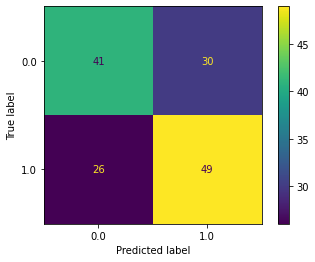

In [491]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn, X_test, y_test)

We have gotten a relatively high number of false negatives.

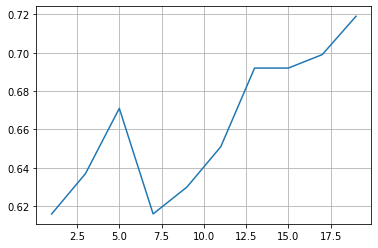

In [492]:
collector = []
for k in range(1, 20, 2):
  accuracy_list = []
  for j in range(1, 10): # I run 10 times and take the mean accuracy
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    prediction = knn.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    accuracy_list.append(accuracy)
  collector.append({"k" : k,
                    "accuracy": round(np.mean(accuracy_list), 3).astype('float64')})

accuracy_scores_minMax_df = pd.DataFrame(collector)

plt.plot(accuracy_scores_minMax_df['k'], accuracy_scores_minMax_df['accuracy'])
plt.grid(True)
plt.show()